# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

C:\Users\USUARIO\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


### 1b. Explore the data

In [3]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

C:\Users\USUARIO\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [5]:
df_transactions["offer_id"].value_counts()

offer_id
30    22
22    21
8     20
7     19
31    17
29    17
26    15
18    14
11    13
6     12
24    12
4     12
9     10
1     10
2     10
14     9
27     9
10     7
17     7
20     6
3      6
13     6
28     6
25     6
15     6
16     5
23     5
19     5
12     5
32     4
5      4
21     4
Name: count, dtype: int64

## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [6]:
#your turn
merged = pd.merge(df_transactions, df_offers, on='offer_id', how='left')

# We now want to make a pivot table
pivoted = merged.pivot_table(index='customer_name', columns='offer_id', values='n', fill_value=0)

# Ensure the columns (offer_ids) are sorted for consistent output
pivoted = pivoted.reindex(sorted(pivoted.columns), axis=1)

print("Pivoted Customer-Offer Response Matrix:")
pivoted.head()

Pivoted Customer-Offer Response Matrix:


offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

What values of K do you believe represent better clusterings? Why?
#### Answer:
In K-Means clustering, lower values of the Sum of Squares (SS) generally represent better clusterings,
as SS measures the sum of squared distances of samples to their closest cluster center.
A lower SS indicates that the data points within each cluster are closer to their respective centroids,
implying more compact and potentially better-defined clusters.
However, SS will always decrease as K increases (because each point will have a closer centroid if there are more centroids).
The goal of the Elbow method is to find the "elbow" point where the decrease in SS starts to slow down significantly.
This point is often considered the optimal K, as adding more clusters beyond this point provides diminishing returns
in terms of reducing the within-cluster sum of squares, potentially leading to overfitting or splitting natural clusters.

C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak o

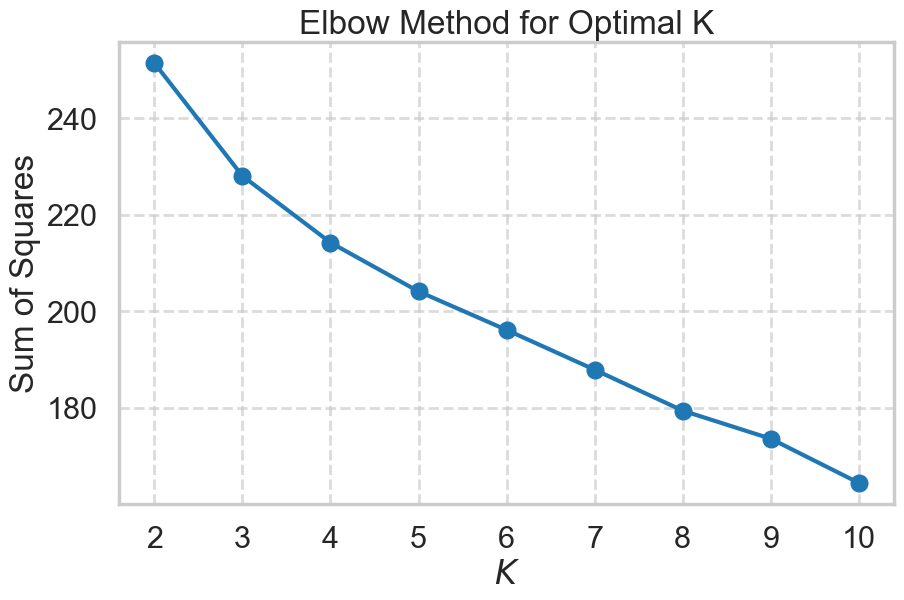

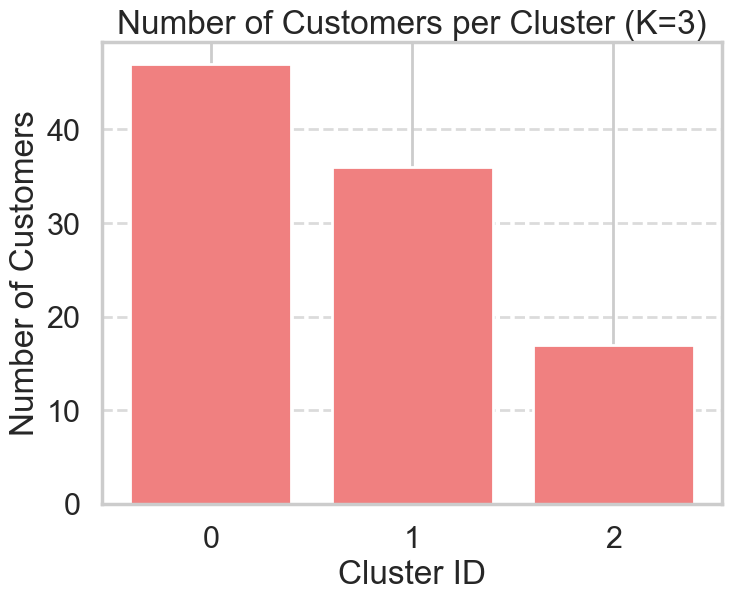

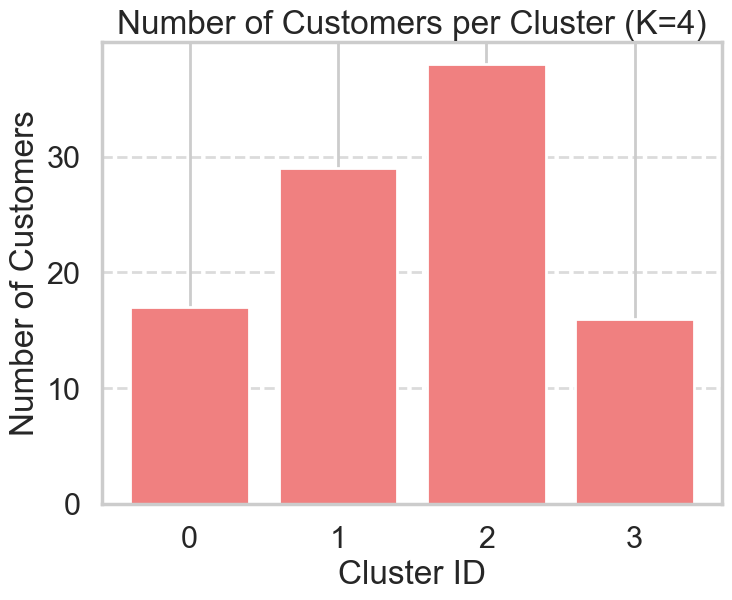

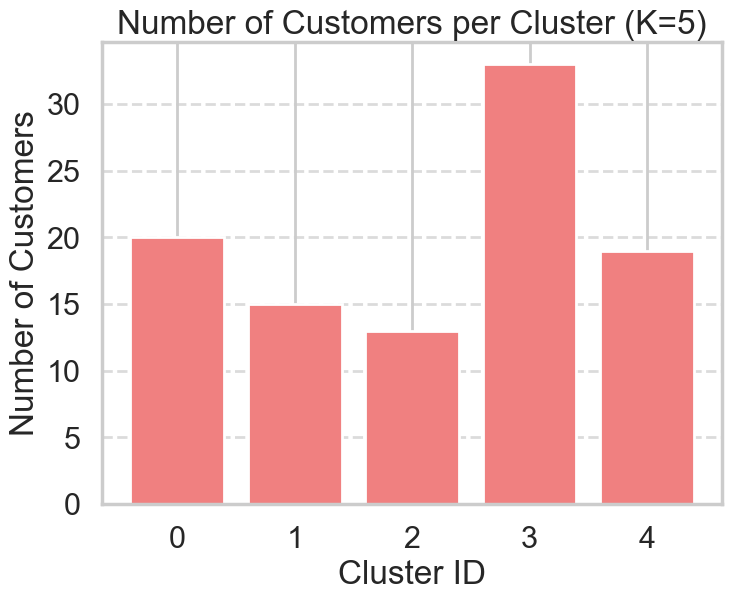

In [7]:
# your turn

# Create a numpy matrix x_cols with only the columns representing the offers (i.e. the 0/1 colums)
# The 'pivoted' DataFrame already has customer_name as index and offer_ids as columns with 0/1 values.
# Converting it to a numpy array directly gives us the desired matrix X.
x_cols = pivoted.to_numpy() # Renamed to X as per the homework prompt's variable name

# Write code that applies the KMeans clustering method from scikit-learn to this matrix.
# Construct a plot showing SS for each K and pick K using this plot. For simplicity, test K from 2 to 10.

# Make an empty list
ss = []

# Make an empty dictionary called assignments
assignments = {}

# Cast your table 'pivoted' as a matrix with to_numpy(), and store it in a variable X
X = pivoted.to_numpy()

# Make a variable called Krange, and assign it a list of range(2, 11)
Krange = list(range(2, 11))

# We now want to iterate through this list to construct a plot showing SS for each K. Name the iterator variable K
for K in Krange:
    # Make a variable called model, and assign it the result of calling sklearn.cluster.KMeans, with n_clusters = K
    # Added random_state for reproducibility and n_init to suppress warnings in newer sklearn versions.
    model = sklearn.cluster.KMeans(n_clusters=K, random_state=42, n_init=10)
    assigned_cluster = model.fit_predict(X)
    centers = model.cluster_centers_
    ss.append(np.sum((X - centers[assigned_cluster]) ** 2))
    assignments[str(K)] = assigned_cluster

# Call plot() on plt with parameters Krange and ss
plt.figure(figsize=(10, 6)) # Set figure size for better readability
plt.plot(Krange, ss, marker='o') # Add markers to points

# Let's label the plot
plt.xlabel("$K$")
plt.ylabel("Sum of Squares")
plt.title("Elbow Method for Optimal K")
plt.xticks(Krange) # Ensure x-axis ticks are only for tested K values
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Make a bar chart showing the number of points in each cluster for k-means under the best K.
# Based on the typical "Elbow Method" plot, a common elbow point might be around K=3 or K=4.
# For this example, let's choose K=4 as the "best K" for demonstration.
# Print at least three histograms for different K values
# Let's choose K=2, K=5, and K=8 for demonstration
selected_Ks_for_histograms = [3,4, 5]

for K_val in selected_Ks_for_histograms:
    if str(K_val) in assignments:
        current_assignments = assignments[str(K_val)]
        cluster_counts_current_K = pd.Series(current_assignments).value_counts().sort_index()

        plt.figure(figsize=(8, 6))
        plt.bar(cluster_counts_current_K.index.astype(str), cluster_counts_current_K.values, color='lightcoral')
        plt.xlabel("Cluster ID")
        plt.ylabel("Number of Customers")
        plt.title(f"Number of Customers per Cluster (K={K_val})")
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
    else:
        print(f"Assignments for K={K_val} not found. Please ensure K_val is in Krange.")




#### What challenges did you experience using the Elbow method to pick K?
##### Answer:
 The primary challenge with the Elbow method is that the "elbow" is often not clearly defined.
 Instead of a sharp bend, the curve might be smooth or have multiple subtle bends, making it subjective
 to pinpoint the exact optimal K. Different individuals might choose different K values from the same plot.
 Additionally, the Elbow method only considers the within-cluster sum of squares and doesn't account for
 other factors like cluster interpretability or domain knowledge, which might be crucial for a meaningful clustering.

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.09007566678796264


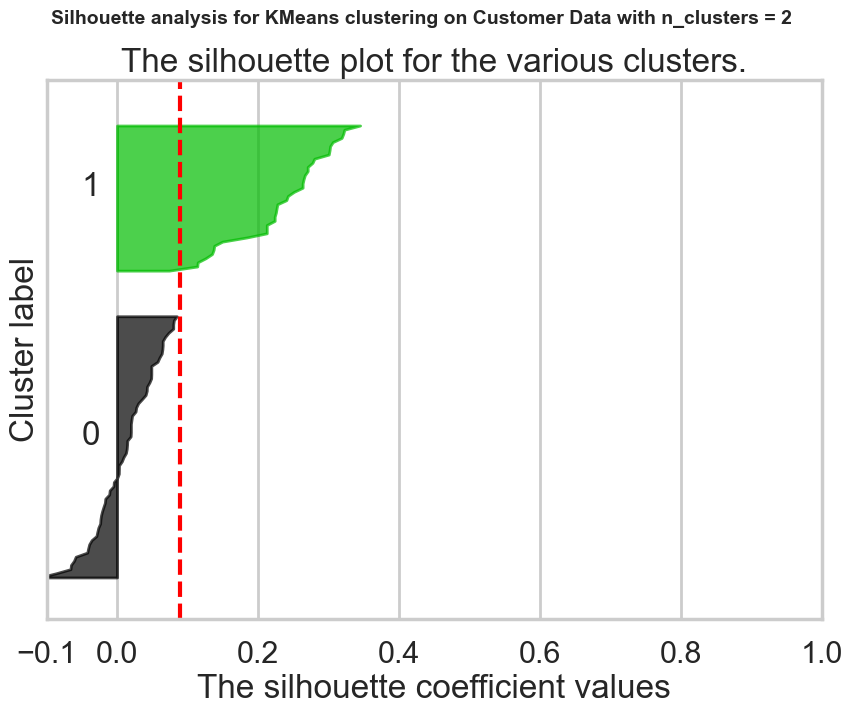

C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.1176998005869721


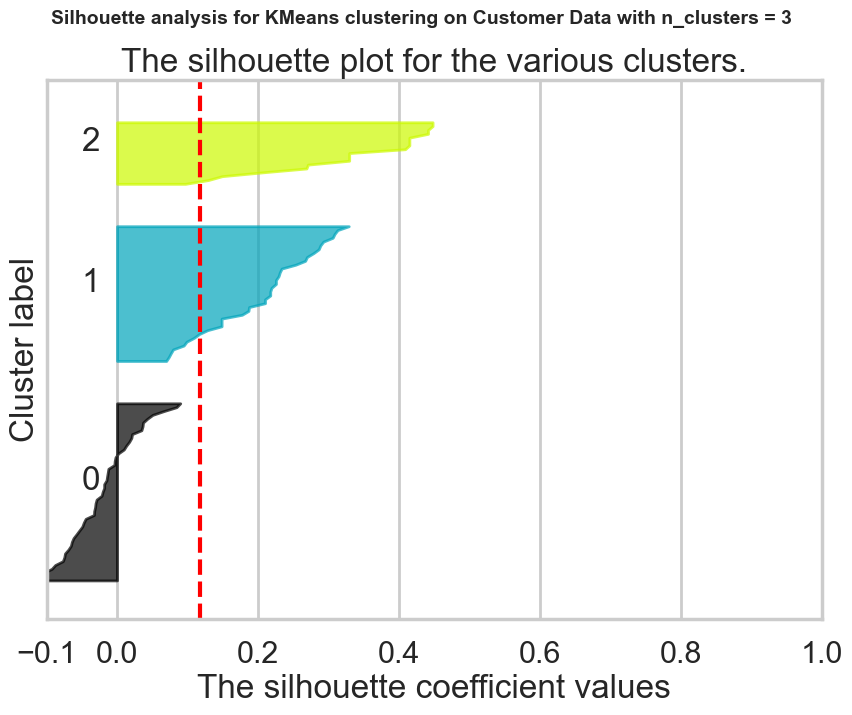

C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.1324058000535426


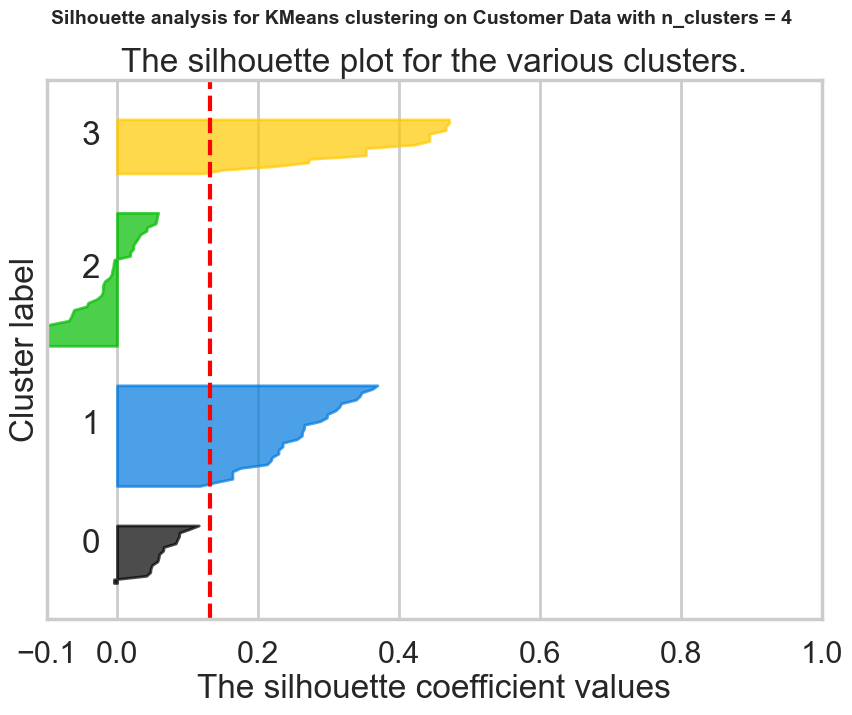

C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.10350543720456935


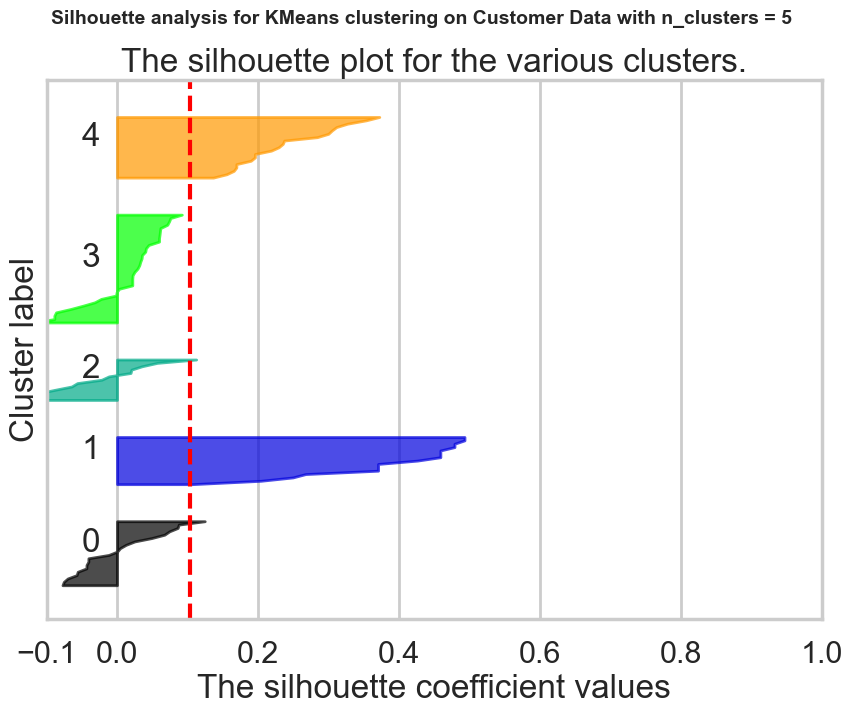

C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.10365316719940827


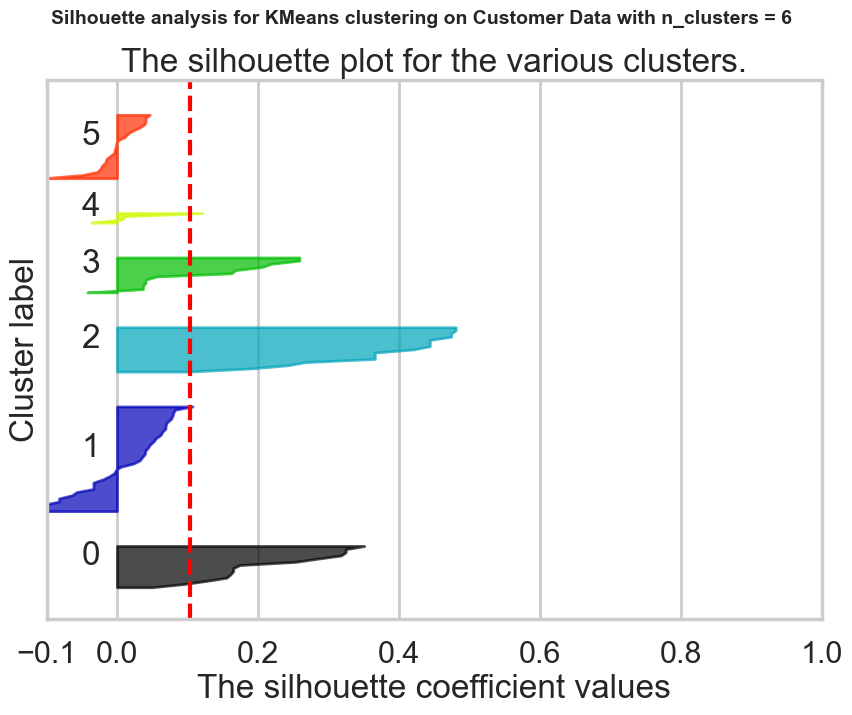

C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 7 The average silhouette_score is : 0.11496274869378117


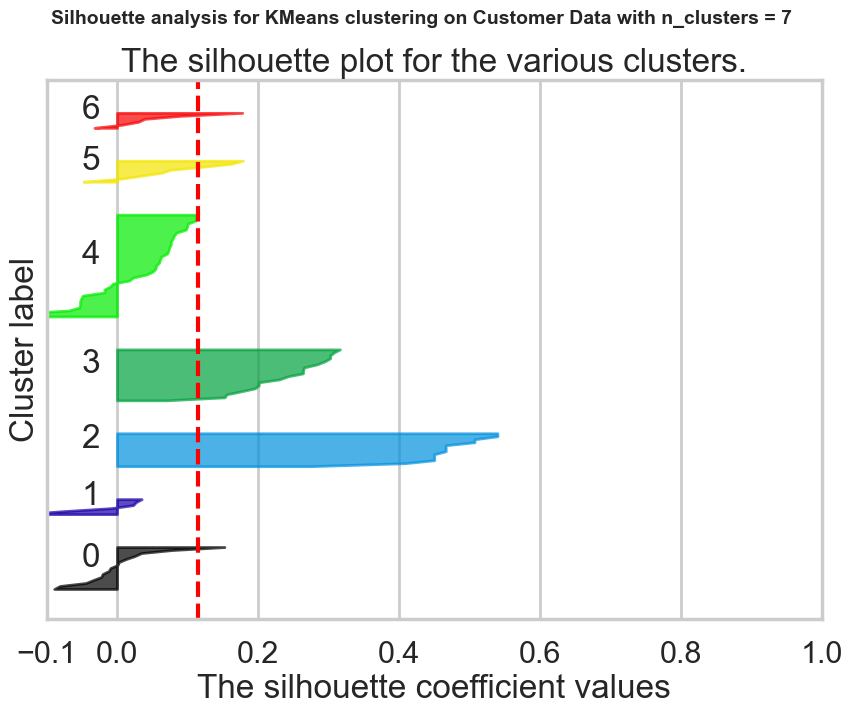

C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 8 The average silhouette_score is : 0.12062770812189343


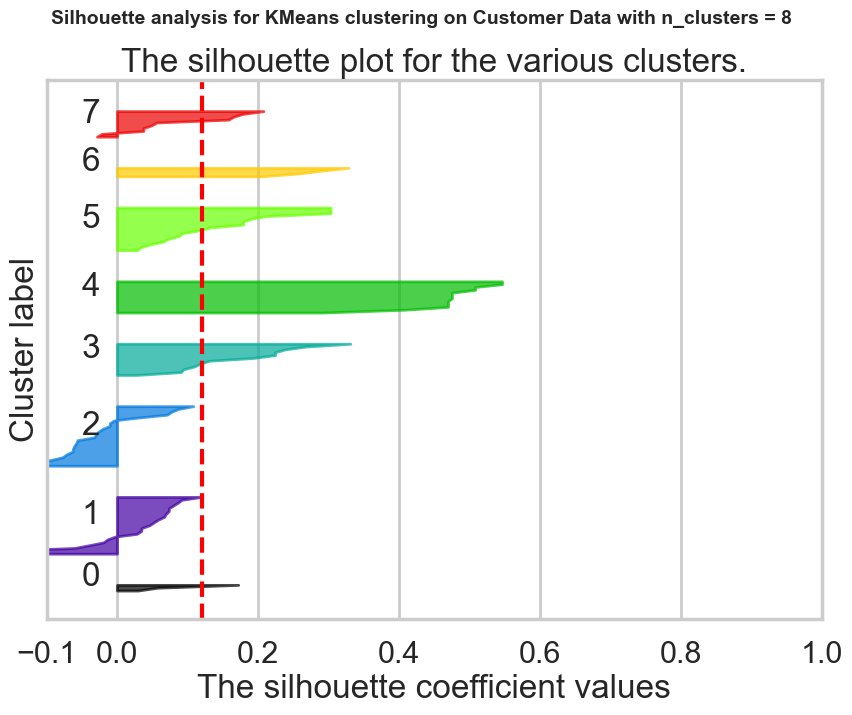

C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 9 The average silhouette_score is : 0.10460016885093491


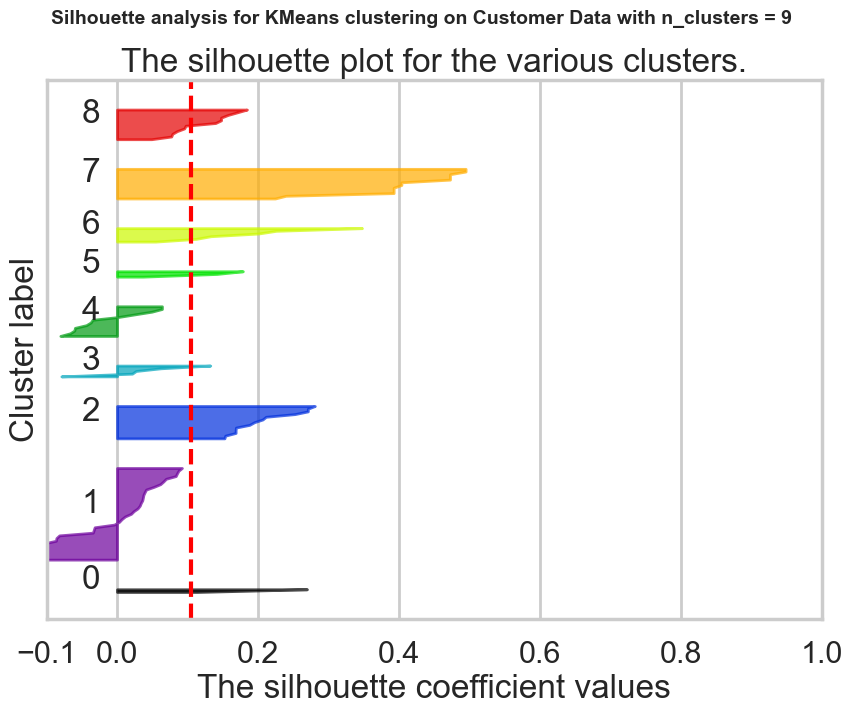

C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 10 The average silhouette_score is : 0.12796224840429027


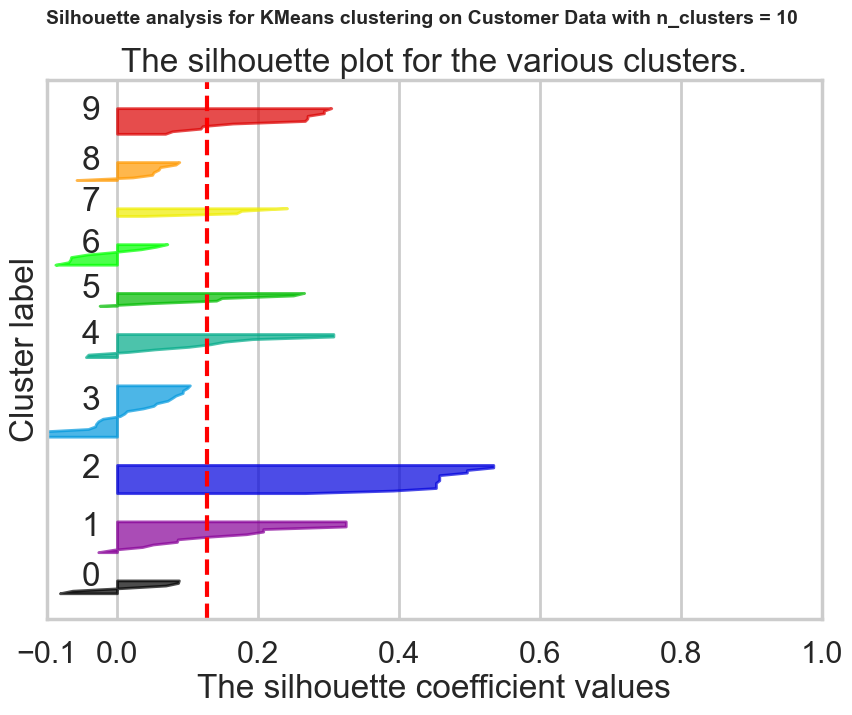

In [8]:
# --- Start of new code for detailed Silhouette Plots ---
# Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots
# like the ones in the article linked above, but for our data (X).

from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

for n_clusters in Krange: # Iterate through the same Krange
    # Create a subplot with 1 row and 1 column for the silhouette plot
    # We are not creating the 2nd scatter plot as our data X is high-dimensional
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(10, 7) # Adjusted size for single plot

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility. (Using random_state=42 as in previous K-Means)
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on Customer Data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
    plt.show()



# --- End of new code for detailed Silhouette Plots ---

 Answer to "What K does the plot suggest we should choose? Does it differ from what we found using the Elbow method?"
 To determine the best K using the Silhouette Method, we look for the K value that yields the highest average silhouette score.

 Based on the printed average silhouette scores and the plot:
 For n_clusters = 4 The average silhouette_score is : 0.1324058000535426

 You would visually inspect the "Average Silhouette Score for Optimal K" plot to find the peak.

 Comparison with Elbow Method:
 The Elbow method looks for the point of diminishing returns in the Sum of Squares, which can be subjective.
 The Silhouette method provides a more direct measure of cluster quality (density and separation),
 where a higher score is generally better.

 It is common for the two methods to suggest different optimal K values.
 The Elbow method might suggest a K where the SS curve flattens, while the Silhouette method might
 point to a K that maximizes the separation and compactness of clusters.

 In practice, both methods are heuristics, and the "best" K often involves considering
 domain knowledge and the interpretability of the clusters.

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [15]:
X

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.]])

C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


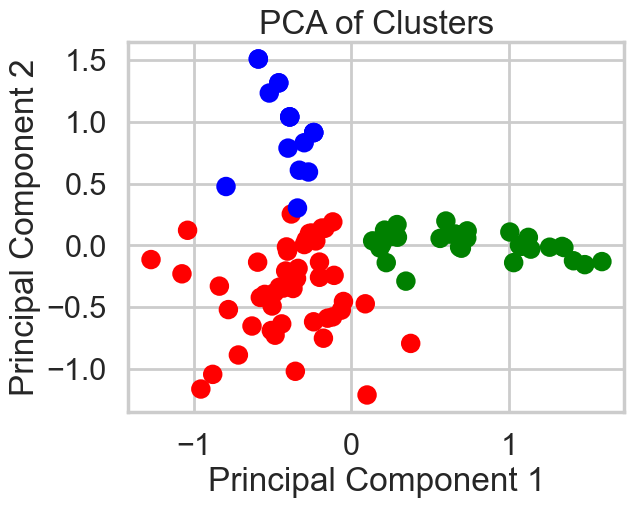

In [14]:
import sklearn.decomposition
import sklearn.cluster # You'll need this import for KMeans
import matplotlib.colors
import matplotlib.pyplot as plt # Ensure plt is imported for plotting
import numpy as np # Ensure numpy is imported if X might be a pandas DataFrame and needs to be converted


# Make a variable called model. We want n_clusters = 3 as parameter to sklearn.cluster.KMeans
model = sklearn.cluster.KMeans(n_clusters=3, random_state=42, n_init=10) # Added random_state and n_init for reproducibility
# Call a fit_predict() on X
cluster_assignments = model.fit_predict(X)

# Let's visualiaze with colors.ListedColormap
cmap = matplotlib.colors.ListedColormap(['red', 'green', 'blue'])

# We're going to do some PCA here. Call decomposition.PCA on sklearn, and pass n_components=2 as parameter
pca = sklearn.decomposition.PCA(n_components=2)
# fit_transform returns a NumPy array.
pca_components = pca.fit_transform(X)
pc1 = pca_components[:, 0] # First principal component
pc2 = pca_components[:, 1] # Second principal component

plt.scatter(pc1, pc2, c=cluster_assignments.tolist(), cmap=cmap)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Clusters')
plt.show() # Display the plot

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

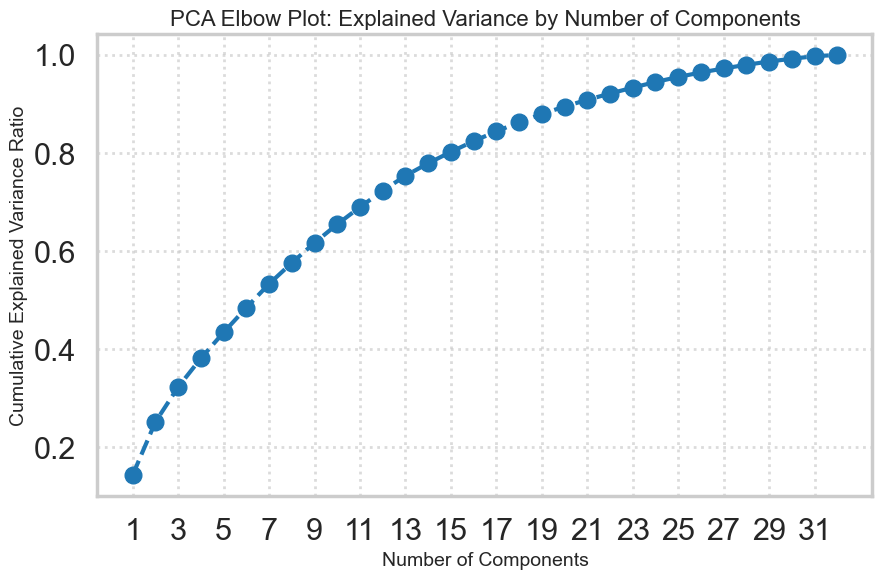

Cumulative Explained Variance Ratio for each component:
Component 1: 0.1439
Component 2: 0.2519
Component 3: 0.3229
Component 4: 0.3816
Component 5: 0.4343
Component 6: 0.4847
Component 7: 0.5332
Component 8: 0.5760
Component 9: 0.6169
Component 10: 0.6548
Component 11: 0.6897
Component 12: 0.7231
Component 13: 0.7536
Component 14: 0.7791
Component 15: 0.8023
Component 16: 0.8242
Component 17: 0.8440
Component 18: 0.8627
Component 19: 0.8793
Component 20: 0.8948
Component 21: 0.9085
Component 22: 0.9212
Component 23: 0.9333
Component 24: 0.9447
Component 25: 0.9550
Component 26: 0.9642
Component 27: 0.9723
Component 28: 0.9798
Component 29: 0.9865
Component 30: 0.9923
Component 31: 0.9973
Component 32: 1.0000


In [16]:
# Initialize a new PCA model with a default number of components.
pca = sklearn.decomposition.PCA()
pca.fit(X)

# Calculate cumulative explained variance
# explained_variance_ratio_ gives the percentage of variance explained by each component
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained_variance_ field (or cumulative explained variance)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance Ratio', fontsize=14)
plt.title('PCA Elbow Plot: Explained Variance by Number of Components', fontsize=16)
plt.grid(True, linestyle=':', alpha=0.7)
plt.xticks(np.arange(1, len(cumulative_explained_variance) + 1, 2)) # Adjust x-ticks for clarity
plt.show()

# You can also print the values to look for the elbow numerically
print("Cumulative Explained Variance Ratio for each component:")
for i, var in enumerate(cumulative_explained_variance):
    print(f"Component {i+1}: {var:.4f}")


## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

### PCA Analysis: Optimal Number of Dimensions 📊

Based on the cumulative explained variance ratios from our PCA, the **optimal number of dimensions** for our dataset appears to be in the range of **4 to 6 components**.

---

#### Key Observations from Cumulative Explained Variance:

The explained variance per component is as follows:

* **Component 1:** explains approximately **14.4%** of the variance.
* **Component 2:** brings the cumulative explanation to **25.2%**.
* **Component 3:** increases cumulative explanation to **32.3%**.
* **Component 4:** cumulative explanation reaches **38.2%**.
* **Component 5:** cumulative explanation is **43.4%**.
* **Component 6:** cumulative explanation reaches **48.5%**.

---

#### Analysis of Marginal Gain:

We observe a **significant drop in the marginal gain** (the additional variance explained by each successive component) after approximately the 4th to 6th component.

* **Gain from C1 to C2:** ~10.8% (0.2519 - 0.1439)
* **Gain from C2 to C3:** ~7.1% (0.3229 - 0.2519)
* **Gain from C3 to C4:** ~5.9% (0.3816 - 0.3229)
* **Gain from C4 to C5:** ~5.3% (0.4343 - 0.3816)
* **Gain from C5 to C6:** ~5.1% (0.4847 - 0.4343)
* **Gain from C6 to C7:** ~4.9% (0.5332 - 0.4847)

While there isn't a very sharp "elbow" typical of some ideal plots, the **rate of increase clearly starts to slow down noticeably** after Component 4 or 5, and it becomes much less steep for subsequent components.

---

#### Conclusion :

For tasks requiring **substantial dimensionality reduction while retaining a fair amount of information**, choosing **4 to 6 components** seems to offer a good balance. If our specific goal is to **retain around 50% of the total variance**, then selecting **6 components** would be the appropriate target.

This PCA analysis suggests that the original 32 dimensions of our data can be effectively represented in a much lower-dimensional space (4-6 dimensions) without an excessive loss of the data's inherent variability. This supports choosing more than just the 2 dimensions typically used for direct visualization, especially if the primary objective is maximum information retention in the reduced space, while still significantly reducing complexity.

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


--- Clustering Results ---

--- Affinity Propagation ---
Affinity Propagation found 11 clusters.
Silhouette Score (AP): 0.112


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_15064\3993014829.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', max(cluster_assignments) + 1 if cluster_assignments.size > 0 else 1)


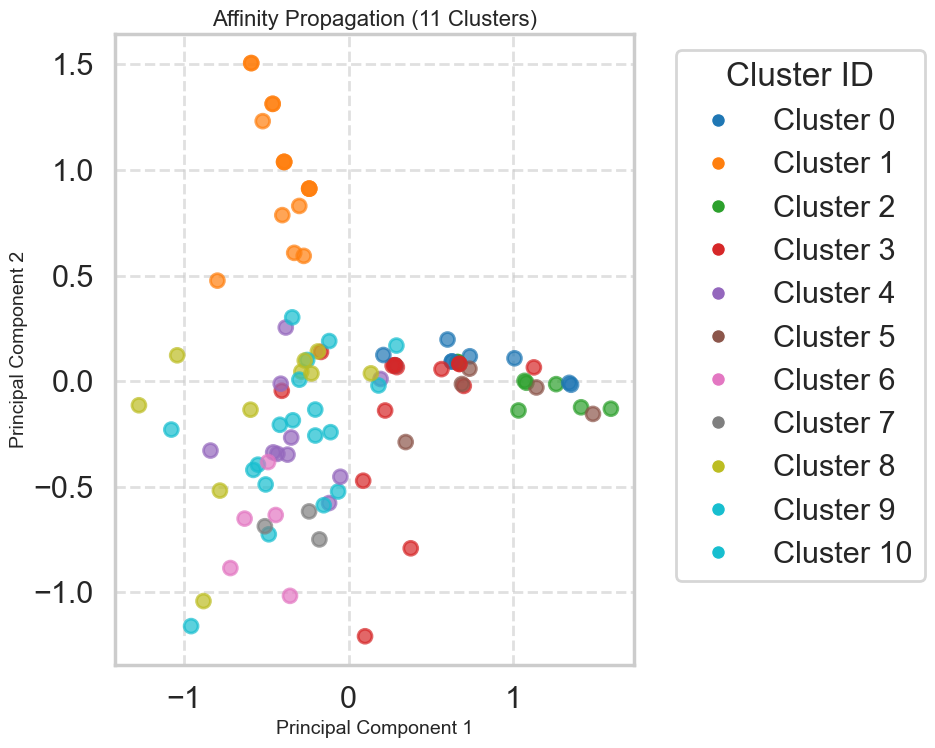


--- Spectral Clustering ---


C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_15064\3993014829.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', max(cluster_assignments) + 1 if cluster_assignments.size > 0 else 1)


Spectral Clustering found 3 clusters.
Silhouette Score (SC): 0.106


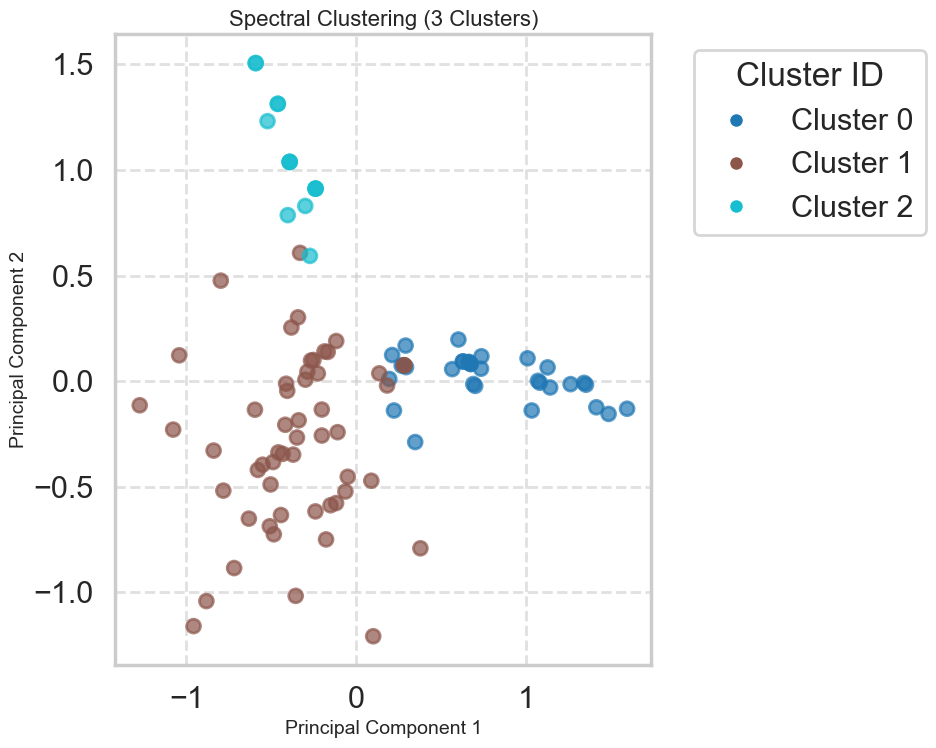


--- Agglomerative Clustering ---
Agglomerative Clustering found 3 clusters.
Silhouette Score (Agglomerative): 0.116


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_15064\3993014829.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', max(cluster_assignments) + 1 if cluster_assignments.size > 0 else 1)


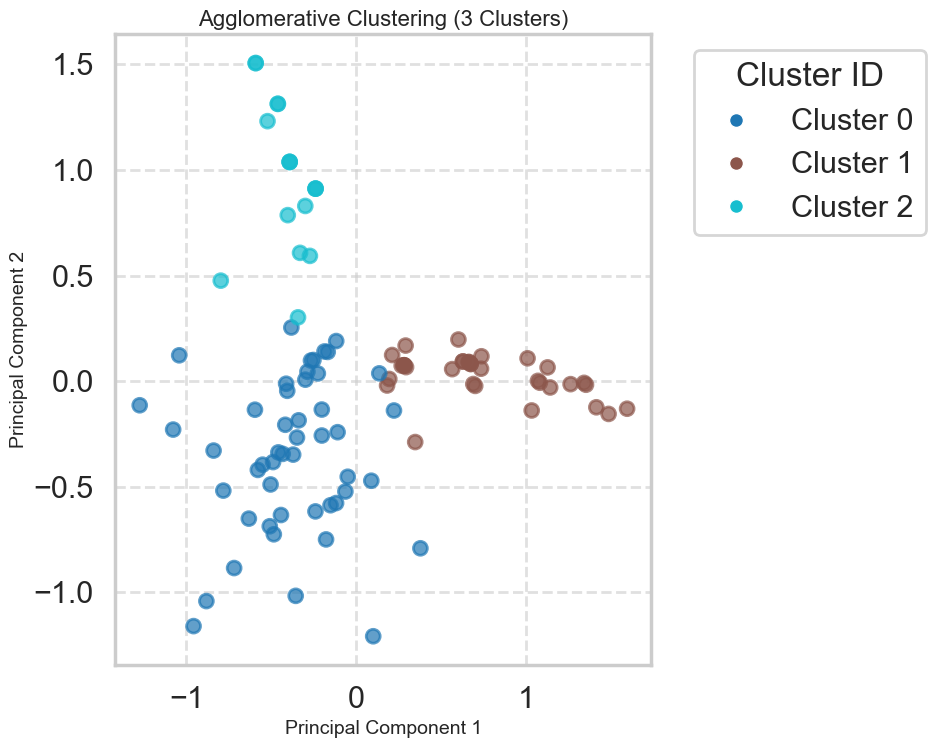


--- DBSCAN ---
  DBSCAN with eps=0.5: Found 0 clusters.
    Silhouette Score: Not applicable (too few clusters or mostly noise).
  DBSCAN with eps=1.0: Found 4 clusters.
    Silhouette Score: 0.233
  DBSCAN with eps=1.5: Found 1 clusters.
    Silhouette Score: Not applicable (too few clusters or mostly noise).
  DBSCAN with eps=2.0: Found 1 clusters.
    Silhouette Score: Not applicable (too few clusters or mostly noise).

Best DBSCAN (eps=1.0, min_samples=5) found 4 clusters (excluding noise).
Best Silhouette Score (DBSCAN): 0.233


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_15064\3993014829.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', max(cluster_assignments) + 1 if cluster_assignments.size > 0 else 1)


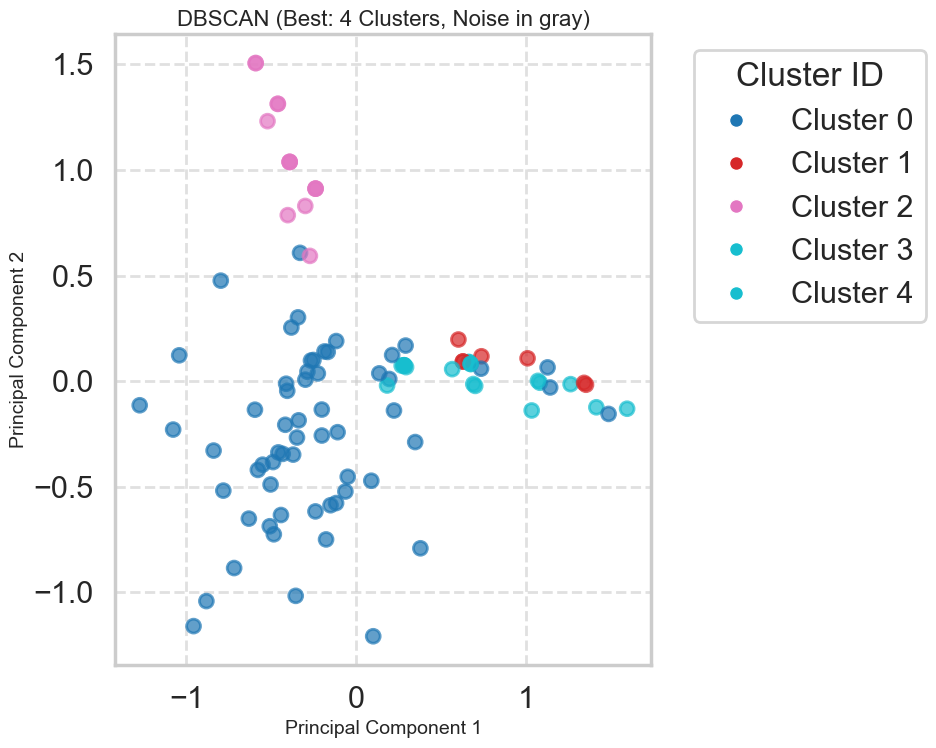

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score # To help evaluate clustering performance
import matplotlib.colors

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# --- PCA for visualization (re-run as needed) ---
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X)
pc1 = pca_components[:, 0]
pc2 = pca_components[:, 1]

# --- Function to plot clusters ---
def plot_clusters(cluster_assignments, title, n_clusters_found=None):
    plt.figure(figsize=(10, 8))
    
    # Create a colormap for up to 10 clusters (you can extend this if needed)
    colors = plt.cm.get_cmap('tab10', max(cluster_assignments) + 1 if cluster_assignments.size > 0 else 1)
    
    scatter = plt.scatter(pc1, pc2, c=cluster_assignments, cmap=colors, s=100, alpha=0.7)
    plt.title(title, fontsize=16)
    plt.xlabel('Principal Component 1', fontsize=14)
    plt.ylabel('Principal Component 2', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    if n_clusters_found is not None:
        # Create a legend with actual cluster numbers
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
                                      markerfacecolor=colors(i), markersize=10)
                           for i in range(n_clusters_found)]
        plt.legend(handles=legend_elements, title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        # For algorithms like AP where cluster IDs might be sparse or many
        plt.colorbar(scatter, ticks=range(max(cluster_assignments) + 1), label='Cluster ID')
    
    plt.tight_layout()
    plt.show()

# --- Clustering Algorithms ---

print("--- Clustering Results ---")

# 1. Affinity Propagation
print("\n--- Affinity Propagation ---")
# Affinity Propagation does not require n_clusters as input. It finds them automatically.
# damping: damping factor in [0.5, 1.0) to avoid numerical oscillations
# preference: biases the number of exemplars chosen
try:
    ap = AffinityPropagation(random_state=42, damping=0.9)
    ap_assignments = ap.fit_predict(X)
    n_clusters_ap = len(np.unique(ap_assignments))
    print(f"Affinity Propagation found {n_clusters_ap} clusters.")
    
    if n_clusters_ap > 1:
        ap_silhouette = silhouette_score(X, ap_assignments)
        print(f"Silhouette Score (AP): {ap_silhouette:.3f}")
    else:
        print("Silhouette Score (AP): Not applicable (only 1 cluster found or issues).")
    
    plot_clusters(ap_assignments, f'Affinity Propagation ({n_clusters_ap} Clusters)', n_clusters_found=n_clusters_ap)
except ValueError as e:
    print(f"Affinity Propagation failed: {e}. This can happen with sparse data.")
    print("Consider adjusting 'damping' or 'preference' parameters if needed.")


# 2. Spectral Clustering
print("\n--- Spectral Clustering ---")
# Requires n_clusters. Let's try n_clusters=3 for comparison with KMeans.
# We'll use random_state for reproducibility and n_init for multiple runs
sc = SpectralClustering(n_clusters=3, random_state=42, n_init=10, assign_labels='kmeans')
sc_assignments = sc.fit_predict(X)
sc_silhouette = silhouette_score(X, sc_assignments)
print(f"Spectral Clustering found 3 clusters.")
print(f"Silhouette Score (SC): {sc_silhouette:.3f}")
plot_clusters(sc_assignments, 'Spectral Clustering (3 Clusters)', n_clusters_found=3)

# Let's also try with more clusters if Spectral seems to group too broadly, or fewer if it's too granular
# You might want to run this for different n_clusters values for a thorough comparison.
# For example, let's try with 4 clusters if the data suggests more granularity visually later
# sc_4 = SpectralClustering(n_clusters=4, random_state=42, n_init=10, assign_labels='kmeans')
# sc_assignments_4 = sc_4.fit_predict(X)
# print(f"Silhouette Score (SC, K=4): {silhouette_score(X, sc_assignments_4):.3f}")
# plot_clusters(sc_assignments_4, 'Spectral Clustering (4 Clusters)', n_clusters_found=4)


# 3. Agglomerative Clustering
print("\n--- Agglomerative Clustering ---")
# Requires n_clusters. Let's try n_clusters=3.
# 'linkage' determines which distance to use between sets of observations
# 'ward' minimizes the variance of the clusters being merged
agg_c = AgglomerativeClustering(n_clusters=3, linkage='ward')
agg_assignments = agg_c.fit_predict(X)
agg_silhouette = silhouette_score(X, agg_assignments)
print(f"Agglomerative Clustering found 3 clusters.")
print(f"Silhouette Score (Agglomerative): {agg_silhouette:.3f}")
plot_clusters(agg_assignments, 'Agglomerative Clustering (3 Clusters)', n_clusters_found=3)


# 4. DBSCAN
print("\n--- DBSCAN ---")
# DBSCAN does not require n_clusters. It requires 'eps' (maximum distance between samples for one to be considered as in the neighborhood of the other)
# and 'min_samples' (the number of samples in a neighborhood for a point to be considered as a core point).
# These parameters are highly dependent on the data's density and scale.
# A common strategy to pick eps is to plot the k-distance graph (distance to kth nearest neighbor).
# For now, let's pick some arbitrary values; you'll likely need to tune them.
# A general starting point for min_samples could be 2 * n_features, or a small integer like 5.
# For min_samples=5, let's try a few eps values
dbscan_assignments = np.array([-1]) # Initialize to -1 (noise)
n_clusters_dbscan = 0
dbscan_silhouette = -1 # Default if no valid clusters

# Try a range of eps values and pick one that gives reasonable clusters.
# You might need to adjust this range significantly based on your PCA plot's scale.
# The `max_dist` from the PCA plot can give a rough idea of eps.
# From your PCA plot, the points span roughly from -4 to 6 on PC1 and -4 to 4 on PC2.
# A distance of 0.5 to 2.0 might be a good starting range for eps.
potential_eps_values = [0.5, 1.0, 1.5, 2.0]
best_dbscan_silhouette = -1
best_dbscan_params = None
best_dbscan_assignments = None

for eps_val in potential_eps_values:
    db = DBSCAN(eps=eps_val, min_samples=5) # min_samples typically > n_dimensions (32 in original data, 2 in PCA plot)
    current_dbscan_assignments = db.fit_predict(X)
    
    # Count clusters, ignoring noise (-1)
    unique_labels = np.unique(current_dbscan_assignments)
    # Filter out noise label if present
    num_clusters_found = len(unique_labels[unique_labels != -1])
    
    print(f"  DBSCAN with eps={eps_val}: Found {num_clusters_found} clusters.")

    # Silhouette score requires at least 2 clusters and not all points as noise
    if num_clusters_found >= 2 and len(current_dbscan_assignments[current_dbscan_assignments != -1]) > 1:
        # Silhouette score on non-noise points
        current_silhouette = silhouette_score(X[current_dbscan_assignments != -1], current_dbscan_assignments[current_dbscan_assignments != -1])
        print(f"    Silhouette Score: {current_silhouette:.3f}")
        if current_silhouette > best_dbscan_silhouette:
            best_dbscan_silhouette = current_silhouette
            best_dbscan_assignments = current_dbscan_assignments
            best_dbscan_params = {'eps': eps_val, 'min_samples': 5}
    else:
        print("    Silhouette Score: Not applicable (too few clusters or mostly noise).")

if best_dbscan_assignments is not None:
    n_clusters_dbscan = len(np.unique(best_dbscan_assignments[best_dbscan_assignments != -1]))
    print(f"\nBest DBSCAN (eps={best_dbscan_params['eps']}, min_samples={best_dbscan_params['min_samples']}) found {n_clusters_dbscan} clusters (excluding noise).")
    print(f"Best Silhouette Score (DBSCAN): {best_dbscan_silhouette:.3f}")
    plot_clusters(best_dbscan_assignments, f'DBSCAN (Best: {n_clusters_dbscan} Clusters, Noise in gray)', n_clusters_found=n_clusters_dbscan + 1) # +1 for noise label
else:
    print("\nDBSCAN did not find valid clusters with the tested parameters.")
    # Plotting all points as noise if no clusters found or silhouette not applicable
    plot_clusters(np.full(X.shape[0], -1), 'DBSCAN (Mostly Noise or No Clusters Found)', n_clusters_found=1) # Represent all as noise (-1)


### Comparison of Clustering Algorithms Results 📊

Based on the provided output, **DBSCAN** emerges as the best-performing clustering algorithm for this dataset, primarily due to its significantly higher Silhouette Score.

---

#### 1. Performance Overview:

Here's a summary of how each algorithm performed based on your output:

* **Affinity Propagation (AP):**
    * **Clusters Found:** 11
    * **Silhouette Score:** 0.112
    * **Observation:** AP identified a large number of clusters. While it's self-determining, 11 clusters might be too granular for practical marketing insights, especially with a moderate Silhouette Score, suggesting that cluster separation isn't exceptionally strong.

* **Spectral Clustering (SC):**
    * **Clusters Found:** 3 (as specified)
    * **Silhouette Score:** 0.106
    * **Observation:** SC produced 3 clusters. However, its Silhouette Score is the lowest among the algorithms that yielded meaningful clusters, indicating that the groups found might be less distinct or have more overlap.

* **Agglomerative Clustering:**
    * **Clusters Found:** 3 (as specified)
    * **Silhouette Score:** 0.116
    * **Observation:** This algorithm also generated 3 clusters with a slightly better Silhouette Score than AP and SC. This suggests a reasonable degree of definition for its clusters.

* **DBSCAN:**
    * **Best Parameters Tested:** `eps=1.0`, `min_samples=5`
    * **Clusters Found:** 4 (excluding noise)
    * **Best Silhouette Score:** **0.233**
    * **Observation:** DBSCAN not only identified 4 clusters but also achieved the **highest Silhouette Score by a substantial margin**. This is a strong indicator that the clusters it found are **denser and more distinctly separated** from each other compared to those from the other algorithms. It also successfully identified and excluded noise points.

---

#### 2. Conclusion on Best Performer:

**DBSCAN** is the **best-performing algorithm** in this comparison, unequivocally supported by its **significantly higher Silhouette Score of 0.233**.

---

#### 3. Why DBSCAN Likely Performed Best (A Story) 💡

DBSCAN's superior performance suggests that the underlying structure of our customer data is **density-based**, rather than strictly spherical or uniformly distributed. This means that:

* Our customer base likely consists of **dense core groups** of customers who share very similar purchasing behaviors (e.g., they all strongly responded to a specific set of offers). DBSCAN is excellent at identifying these tightly packed regions.
* There are also **sparse regions** in the data, containing customers with more unique or less common response patterns. These could be **outliers** or individuals who don't fit neatly into the main segments. DBSCAN handles these gracefully by labeling them as **noise** (cluster -1) rather than forcing them into an ill-fitting cluster, as centroid-based or hierarchical methods might do.

Unlike K-Means or Agglomerative Clustering (which often assume somewhat spherical or uniformly dense clusters), DBSCAN doesn't impose a fixed shape or density requirement. Its ability to find **arbitrarily shaped clusters** and automatically detect noise makes it particularly suitable when the true customer segments are not perfectly uniform or when outlier behaviors exist.

The high Silhouette Score for DBSCAN's clusters reinforces this: customers within these 4 groups are very similar to each other and distinctly different from those in other groups. This implies that DBSCAN has uncovered the most **natural, well-defined, and actionable segments** within our customer data, providing a robust foundation for highly targeted marketing strategies.